In [1]:
import tarfile
import os
import xml.etree.ElementTree as etree
import pandas as pd
from nltk.corpus import wordnet as wn
from tqdm import tqdm, tnrange, tqdm_notebook
import csv
import json

In [2]:
archived_xml = '../resources/training-data/WSD_Training_Corpora/SemCor/semcor.data.xml'
mapping_file = '../resources/training-data/WSD_Training_Corpora/SemCor/semcor.gold.key.txt'

In [3]:
mapping = pd.read_table(mapping_file, sep = ' ', names = ['sentence_idx', 'sensekey1', 'sensekey2'])

In [4]:
context = etree.iterparse(archived_xml, events=("start", "end"))

with open('../resources/f.csv', 'w', encoding='utf-8') as file:
    
    csv_writer =  csv.writer(file)
    csv_writer.writerow(('id', 'X', 'y','sensekeyCount'))
    
    for idx, (event, elem) in enumerate(tqdm(context)):
        
        if elem.tag == 'sentence' and event == 'start':
            sentence_id = elem.get("id")
            X, y, senseCount = [], [], 0

        if elem.tag == "wf" and event == 'start':
            X.append(elem.text)
            y.append(elem.text)

        if elem.tag == "instance" and event == 'start':
            # get mapping from idx
            m = mapping[mapping['sentence_idx']== elem.get("id")]
            X.append(elem.text)

            #get sensekeys from mapping row
            l = [m['sensekey1'].iloc[0], m['sensekey2'].iloc[0]]
            cleanedList = [x for x in l if str(x) != 'nan'] #gets rid of NaN's
            senseCount += len(cleanedList)
            y.append(cleanedList)

        if elem.tag == 'sentence' and event == 'end':
            csv_writer.writerow([sentence_id, X, y, senseCount])

        if (idx+1)%10000==0:
            print("{:1f}% complete".format((idx/877502)*100))

        elem.clear()
del context

10036it [00:35, 281.03it/s]

1.1394845823713222% complete


16172it [00:56, 285.39it/s]

KeyboardInterrupt: 

16172it [01:10, 230.84it/s]

In [6]:
df = pd.read_csv("../resources/f.csv")

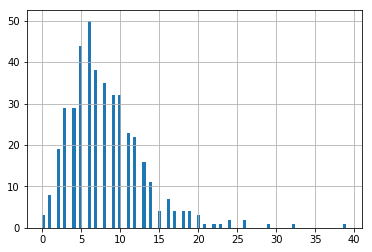

In [24]:
df['sensekeyCount'].hist(bins=100)

-----

In [ ]:
def sensekeyToSynsetConverter(sensekey: str):
    '''retrieves a WordNet synset from a sensekey using the nltk package'''
    synset = wn.lemma_from_key(sensekey).synset()
    
    synset_id = "wn:" + str(synset.offset()).zfill(8) + synset.pos()
    return synset_id

# convert from sensekey to synset ID

In [ ]:
tqdm.pandas(desc="my bar!")
# converting from sensekey to synset id for the two columns
mapping['sensekey1'] = mapping['sensekey1'].progress_apply(sensekeyToSynsetConverter)

In [ ]:
tqdm.pandas(desc="my bar!")
# using notnull() instead of dropna because dropna() does not work on particular columns
mapping['sensekey2'][mapping['sensekey2'].notnull()] = mapping['sensekey2'][mapping['sensekey2'].notnull()].progress_apply(sensekeyToSynsetConverter)

# wordnet to BabelNet

In [ ]:
file = '../resources/babelnet2wordnet.tsv'
BabelNet = pd.read_table(file, sep = '\t', names = ['BabelNet', 'WordNet', 'WordNet2'])
BabelNet.head()

In [ ]:
file = '../resources/babelnet2wndomains.tsv'
WordNet = pd.read_table(file, sep = '\t', names = ['BabelNet', 'WordNetDomain'])
WordNet.head()

In [ ]:
file = '../resources/babelnet2lexnames.tsv'
LexicographerNet = pd.read_table(file, sep = '\t', names = ['BabelNet', 'LexNames'])
LexicographerNet.head()

In [ ]:
context = etree.iterparse(archived_xml, events=("start", "end"))
with open('../resources/f.csv', 'w', encoding='utf-8') as file:
    csv_writer =  csv.writer(file)
    csv_writer.writerow(('id', 'X', 'y','sensekeyCount'))
    
    for idx, (event, elem) in enumerate(tqdm(context)):

        if elem.tag == 'sentence' and event == 'start':
            sentence_id = elem.get("id")
            X, y, senseCount = [], [], []

        if elem.tag == "wf" and event == 'start':
            word = elem.text
            X.append(word)
            y.append(word)

        if elem.tag == "instance" and event == 'start':
            # get mapping from idx
            m = mapping[mapping['sentence_idx']== elem.get("id")]
            # create dict {lemma: [sensekey1, sensekey2]}
            word = elem.text
            X.append(word)

            #get sensekeys from mapping row
            l = [m['sensekey1'].iloc[0], m['sensekey2'].iloc[0]]
            #get rid of nan's if there is only one sensekey instead of two
            cleanedList = [x for x in l if str(x) != 'nan']
            senseCount.append(len(cleanedList))
            y.append(cleanedList)

        if elem.tag == 'sentence' and event == 'end':
            #to_dump = {'x':X, 'y':y}
            csv_writer.writerow([sentence_id, X, y, max(senseCount)])
        if idx==200:
            break
        elem.clear()
del context

In [ ]:
max(senseCount)

In [ ]:
len(senseCount)

In [ ]:
df = pd.read_csv('../resources/f.csv')

In [ ]:
df.iloc[0]['y']

In [ ]:
max(senseCount)

# Predictions:
1. babelnet
2. wordnet_domains
3. lexicographer

In [ ]:
f

In [ ]:
BNet.iloc[0]

In [ ]:
BNet.iloc[0] in WordNet['BabelNet']

In [ ]:
m.iloc[0][1:].dropna()

In [ ]:
sensekeys.iloc[0][0]

In [ ]:
context = etree.iterparse(archived_xml, events=("start", "end"))

with open('../resources/f.csv', 'w', encoding='utf-8') as file:
    
    csv_writer =  csv.writer(file)
    csv_writer.writerow(('id', 'sensekey1', 'sensekey2', 'lemma', 'text'))#, 'BabelNet', 'WordNetDomain', 'LexNames'))
    
    for idx, (event, elem) in enumerate(tqdm(context)):
        if elem.tag == 'sentence' and event == 'start':

            sentence, y = []
        if elem.tag == "wf" and event == 'start':
            word = elem.text
            sentence.append(word)
            y.append(word)
        if elem.tag == "instance" and event == 'start':
            # get mapping from idx
            m = mapping[mapping['sentence_idx']== elem.get("id")]
            # create dict {lemma: [sensekey1, sensekey2]}
            word = elem.text
            sentence.append(word)
            #sensekeys = m.drop(columns=["sentence_idx"]).dropna(axis=1)
            l = [m['sensekey1'].iloc[0], m['sensekey2'].iloc[0]]
            cleanedList = [x for x in l if str(x) != 'nan']
            y.append(cleanedList)
#             csv_writer.writerow([instance_id,
#                                 m['sensekey1'].iloc[0], m['sensekey2'].iloc[0], 
#                                 lemma, text])
        if elem.tag == 'sentence' and event == 'end':
            
            print(sentence)
            print(y)
            

            #get babelnet id from wordnet synset
#             BNet = BabelNet[BabelNet['WordNet'] == m['sensekey1'].iloc[0]]['BabelNet']
#             WordNetDomain = WordNet[WordNet['BabelNet'] == BNet.iloc[0]]['WordNetDomain']
#             LexNet = LexicographerNet[LexicographerNet['BabelNet'] == BNet.iloc[0]]['LexNames']
#             print(list(m.iloc[0]), lemma, text, BNet.iloc[0], WordNetDomain, LexNet.iloc[0])
#             csv_writer.writerow([instance_id,
#                                 m['sensekey1'].iloc[0], m['sensekey2'].iloc[0], 
#                                 lemma, text, 
#                                 BNet.iloc[0], WordNetDomain.iloc[0], LexNet.iloc[0]])
        elem.clear()
del context